# Lab 2


`import interp` [scipy.interpolate.interp2d](https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.interp2d.html)


## Objective

![theory](./Comparison_of_1D_and_2D_interpolation.svg)

## Code

In [1]:
from scipy import interpolate
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image


### Load the image

Load and show the image inline.

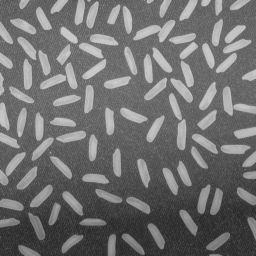

In [2]:
image = Image.open('rice.tif')
image

### Convert the image to numpy array

In [3]:
imarray = np.array(image)
print(imarray.shape)
print(imarray)

(256, 256)
[[122  92  95 ... 101 100  92]
 [ 99  99 102 ... 105  93  93]
 [ 97 107 103 ...  96  95 103]
 ...
 [ 51  58  46 ...  63  49  55]
 [ 52  52  53 ...  65  52  54]
 [ 59  51  52 ...  65  46  42]]


In [4]:
print(imarray.shape[0])

256


### Nearest neighbor

In [5]:
def Nearest_11812418(input_file, dim):
    image = Image.open(input_file)
    imarray = np.array(image)
    #find the dimenssion of input file
    input_height = imarray.shape[0]
    input_width = imarray.shape[1]

    #set the output
    #dim(0) is the height
    #dim(1) is the width
    #init an array
    output_arr = np.zeros(dim)

    #iterate in output array
    for i in range(dim[0]):
        for j in range(dim[1]):
            #i height (dim0)
            #j width (dim1)
            interpolation_h = round((i)*(input_height-1)/(dim[0]-1))
            interpolation_w = round((j)*(input_width-1)/(dim[1]-1))
            output_arr[i][j] = imarray[interpolation_h][interpolation_w]


    return output_arr

#### Testbench

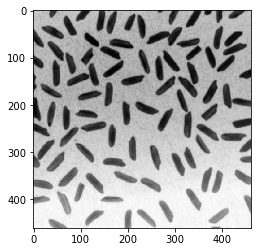

In [6]:
#enlarge
dim = (461,461)
output_img = Nearest_11812418('rice.tif',dim)
im = Image.fromarray(output_img.astype(np.uint8))
im.save("Enlarged_Nearest_11812418.tif")
im.save("Enlarged_Nearest_11812418.png")
plt.imshow(output_img, cmap=plt.cm.Greys)
plt.show()

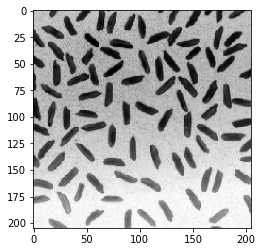

In [7]:
#shrink
dim = (205,205)
output_img = Nearest_11812418('rice.tif',dim)
im = Image.fromarray(output_img.astype(np.uint8))
im.save("Shrinked_Nearest_11812418.tif")
im.save("Shrinked_Nearest_11812418.png")
plt.imshow(output_img, cmap=plt.cm.Greys)
plt.show()

### Bilinear Interpolation

In [8]:
def Bilinear_11812418(input_file, dim):
    image = Image.open(input_file)
    imarray = np.array(image)
    #find the dimenssion of input file
    input_height = imarray.shape[0]
    input_width = imarray.shape[1]

    #set the output
    #dim(0) is the height
    #dim(1) is the width
    #init an array
    output_arr = np.zeros(dim)

    delta_height = 1
    delta_width = 1
    #base: output
    #iterate in output array
    for i in range(dim[0]):
        for j in range(dim[1]):
            #i height (dim0)
            #j width (dim1)

            #start from 1
            #transform to input coordinate
            projected_height = (i)*(input_height-1)/(dim[0]-1)
            projected_width = (j)*(input_width-1)/(dim[1]-1)
            #print(str(projected_height) + ' ' + str(projected_width))

            #find the border

            interpolation_h_up = int(np.ceil(projected_height))
            interpolation_h_down = int(np.floor(projected_height))
            interpolation_w_up = int(np.ceil(projected_width))
            interpolation_w_down = int(np.floor(projected_width))

            k_w_down = (abs(imarray[interpolation_h_up][interpolation_w_down]-imarray[interpolation_h_down][interpolation_w_down]))/delta_height

            w_down_val = imarray[interpolation_h_down][interpolation_w_down] + k_w_down*(projected_height-interpolation_h_down)

            k_w_up = (abs(imarray[interpolation_h_up][interpolation_w_up]-imarray[interpolation_h_down][interpolation_w_up]))/delta_height
            w_up_val = imarray[interpolation_h_down][interpolation_w_up] + k_w_up*(projected_height-interpolation_h_down)


            #special case
            if(projected_height % 1):
                w_down_val = imarray[int(projected_height)][int(projected_width)]
                w_up_val = imarray[int(projected_height)][int(projected_width)]

            if(projected_width % 1):
                interpolation_w_down = projected_width

            k_h = (abs(w_up_val-w_down_val)/delta_width)
            h_val = w_down_val + k_h*(projected_width-interpolation_w_down)

            output_arr[i][j] = h_val
    print(output_arr)
    return output_arr


#### Testbench

<ipython-input-8-90241e4b2a2e>:36: RuntimeWarning: overflow encountered in ubyte_scalars
  k_w_down = (abs(imarray[interpolation_h_up][interpolation_w_down]-imarray[interpolation_h_down][interpolation_w_down]))/delta_height
<ipython-input-8-90241e4b2a2e>:40: RuntimeWarning: overflow encountered in ubyte_scalars
  k_w_up = (abs(imarray[interpolation_h_up][interpolation_w_up]-imarray[interpolation_h_down][interpolation_w_up]))/delta_height


[[122. 122.  92. ... 101. 100.  92.]
 [122. 122.  92. ... 101. 100.  92.]
 [ 99.  99.  99. ... 105.  93.  93.]
 ...
 [ 51.  51.  58. ...  63.  49.  55.]
 [ 52.  52.  52. ...  65.  52.  54.]
 [ 59.  59.  51. ...  65.  46.  42.]]


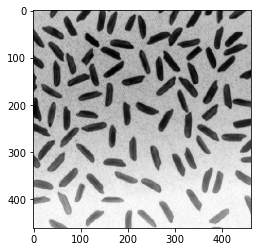

In [17]:
dim = (461,461)
output_img2 = Bilinear_11812418('rice.tif',dim)
im = Image.fromarray(output_img2.astype(np.uint8))
im.save("Enlarged_Bilinear_11812418.tif")
im.save("Enlarged_Bilinear_11812418.png")
plt.imshow(output_img2, cmap=plt.cm.Greys)
plt.show()

<ipython-input-8-90241e4b2a2e>:36: RuntimeWarning: overflow encountered in ubyte_scalars
  k_w_down = (abs(imarray[interpolation_h_up][interpolation_w_down]-imarray[interpolation_h_down][interpolation_w_down]))/delta_height
<ipython-input-8-90241e4b2a2e>:40: RuntimeWarning: overflow encountered in ubyte_scalars
  k_w_up = (abs(imarray[interpolation_h_up][interpolation_w_up]-imarray[interpolation_h_down][interpolation_w_up]))/delta_height


[[122.  92.  95. ...  96. 101.  92.]
 [ 99.  99. 102. ... 106. 105.  93.]
 [ 97. 107. 103. ...  91.  96. 103.]
 ...
 [ 54.  51.  47. ...  67.  65.  58.]
 [ 51.  58.  46. ...  54.  63.  55.]
 [ 59.  51.  52. ...  59.  65.  42.]]


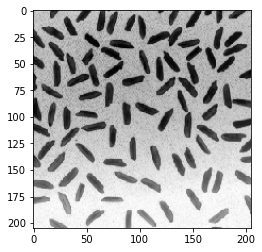

In [18]:
dim = (205,205)
output_img2 = Bilinear_11812418('rice.tif',dim)
im = Image.fromarray(output_img2.astype(np.uint8))
im.save("Shrinked_Bilinear_11812418.tif")
im.save("Shrinked_Bilinear_11812418.png")
plt.imshow(output_img2, cmap=plt.cm.Greys)
plt.show()



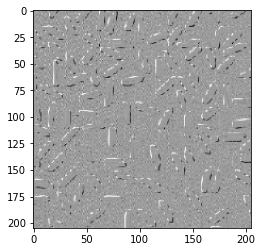

In [11]:
delta_img = output_img2-output_img

plt.imshow(delta_img, cmap=plt.cm.Greys)
plt.show()

### Bicubic with Scipy

[https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.interp2d.html](https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.interp2d.html)

In [19]:
def Bicubic_11812418(input_file, dim):
    image = Image.open(input_file)
    imarray = np.array(image)

    #find the dimenssion of input file
    input_height = imarray.shape[0]
    input_width = imarray.shape[1]

    #set the output
    #dim(0) is the height
    #dim(1) is the width
    #init an array
    output_arr = np.zeros(dim)

    delta_height = 1
    delta_width = 1
    #base: output

    # construct the bicubic function
    def interp2d_bicubic_scipy(array_data,relative_y,relative_x):
        x = [0,1,2,3]
        y = [0,1,2,3]
        f = interpolate.interp2d(y, x, array_data, kind='cubic')
        interp_result = f(relative_y,relative_x)
        return interp_result

    #iterate in output array
    for i in range(dim[0]):
        for j in range(dim[1]):
            #i height (dim0)
            #j width (dim1)

            #start from 1
            #transform to input coordinate
            projected_height = (i)*(input_height-1)/(dim[0]-1)
            projected_width = (j)*(input_width-1)/(dim[1]-1)
            #print(str(projected_height) + ' ' + str(projected_width))

            #find the border
            interpolation_x_floor = int(np.floor(projected_width))
            interpolation_y_floor = int(np.floor(projected_height))

            array16 = []
            for k in range(4): #y
                for l in range(4): #x
                    sample_x = interpolation_x_floor - 1 + l
                    sample_y = interpolation_y_floor - 1 + k
                    if((sample_x<0) or (sample_y<0) or (sample_x + 2>input_width) or (sample_y + 2>input_height)):
                        array16.append(0)
                    else:
                        array16.append(imarray[sample_y][sample_x])

            #print(array16)
            output_arr[i][j] = interp2d_bicubic_scipy(array16,(projected_height-interpolation_y_floor),(projected_width-interpolation_x_floor))

    print(output_arr)
    return output_arr

#### Testbench

[[-3.88376090e-15 -4.48905184e-15 -1.07164354e-14 ...  3.12913956e-15
  -8.10613742e-15 -5.10628417e-15]
 [-3.92773005e-15  7.74576945e+01  9.00931945e+01 ...  7.11675237e+01
   9.36121578e+01  7.55565258e+01]
 [-1.18925505e-14  9.35489024e+01  1.12763999e+02 ...  1.01292067e+02
   1.24606185e+02  9.82229340e+01]
 ...
 [-3.33840324e-15  3.44535897e+01  5.30882791e+01 ...  6.17160131e+01
   6.52176762e+01  4.81128411e+01]
 [-5.13389608e-15  4.68862951e+01  6.53764509e+01 ...  8.01321214e+01
   8.61734132e+01  6.39786570e+01]
 [-3.15590662e-15  3.84040546e+01  5.15850970e+01 ...  6.44866237e+01
   6.98478627e+01  5.20000000e+01]]


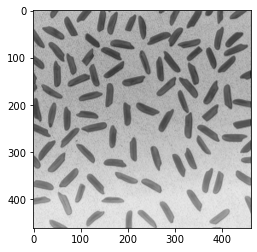

In [20]:
dim = (461,461)
output_img2 = Bicubic_11812418('rice.tif',dim)
im = Image.fromarray(output_img2.astype(np.uint8))
im.save("Enlarged_Bicubic_11812418.tif")
im.save("Enlarged_Bicubic_11812418.png")
plt.imshow(output_img2, cmap=plt.cm.Greys)
plt.show()

[[-3.88376090e-15 -8.85904351e-15 -7.26640786e-15 ... -3.58247599e-15
   3.26124009e-15 -5.10628417e-15]
 [-1.10958902e-14  1.04000183e+02  9.80390625e+01 ...  1.02922363e+02
   1.02026367e+02  9.63671875e+01]
 [-5.35933346e-15  9.94243164e+01  1.10007812e+02 ...  9.87460937e+01
   9.41879883e+01  9.71250000e+01]
 ...
 [-1.43114753e-15  5.31225586e+01  4.85351562e+01 ...  6.19414062e+01
   6.33134766e+01  5.91875000e+01]
 [-3.27063940e-15  5.51715088e+01  4.39819336e+01 ...  5.35795898e+01
   6.00633545e+01  4.72734375e+01]
 [-3.15590662e-15  5.12500000e+01  5.56250000e+01 ...  4.76250000e+01
   6.33281250e+01  5.20000000e+01]]


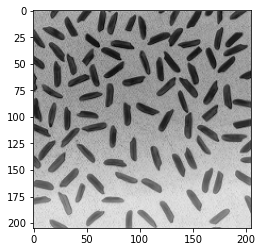

In [21]:
dim = (205,205)
output_img2 = Bicubic_11812418('rice.tif',dim)
im = Image.fromarray(output_img2.astype(np.uint8))
im.save("Shrinked_Bicubic_11812418.tif")
im.save("Shrinked_Bicubic_11812418.png")
plt.imshow(output_img2, cmap=plt.cm.Greys)
plt.show()


In [14]:
delta_img = output_img2-output_img

plt.imshow(delta_img, cmap=plt.cm.Greys)
plt.show()



ValueError: operands could not be broadcast together with shapes (461,461) (205,205) 